Import Modules

In [80]:
import json
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline  
from ast import literal_eval as make_tuple
from scipy import sparse
import numpy as np
from pymongo import MongoClient
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.append('../machine_learning')
import yelp_ml as yml
reload(yml)
from gensim import corpora, models, similarities, matutils
import tqdm

Import Scrapped Reviews

In [10]:
dc_reviews = json.load(open("../Yelp_web_scrapper/dc_reviews.json"))
newyork_reviews = json.load(open("../Yelp_web_scrapper/newyork_reviews.json"))
austin_reviews = json.load(open("../Yelp_web_scrapper/austin_reviews.json"))
chicago_reviews = json.load(open("../Yelp_web_scrapper/chicago_reviews.json"))
la_reviews = json.load(open("../Yelp_web_scrapper/la_reviews.json"))

scrapped_reviews = {'dc': dc_reviews, 'ny': newyork_reviews, 
                    'austin': austin_reviews, 'chicago': chicago_reviews, 
                    'la': la_reviews}

Import Hu & Liu (2004) Word Dictionary and Wrangled Large Users

In [3]:
lh_neg = open('../input/negative-words.txt', 'r').read()
lh_neg = lh_neg.split('\n')
lh_pos = open('../input/positive-words.txt', 'r').read()
lh_pos = lh_pos.split('\n')
users = json.load(open("cleaned_large_user_dictionary.json"))
word_list = list(set(lh_pos + lh_neg))

Connect to the AWS Instance and get the restaurant reviews from the cleaned data database

In [11]:
ip = '54.175.170.119'
conn = MongoClient(ip, 27017)
conn.database_names()
db = conn.get_database('cleaned_data')
reviews = db.get_collection('restaurant_reviews')

For each of the following features we combine them with one of the three models. We perform the testing procedure and collect the results in a dictionary object.

#### Features:
                                 
1. (Sentiment %, TF-IDF w/ (2,2) N-Gram, LSA)
2. (Sentiment %, LSA)
3. (TF-IDF w/ (2,2) N-Gram, LDA, LSA)
4. (Sentiment %, TF-IDF w/ (2,2) N-Gram, LDA, LSA)
                  
#### Models:
1. Linear Support Vector Machine
2. Random Forest
3. Naive Bayes

In [4]:
string_keys_dict = {}
for j in tqdm.tqdm(range(146, 147)):
    
    #Generate a dataframe that has the user's review text, review rating, and restaurant ID
    test_results = {}
    user_df = yml.make_user_df(users[users.keys()[j]])
    
    #Only predict for the user if they have at least 20 bad ratings
    if len([x for x in user_df['rating'] if x < 4]) < 20:
        string_keys_dict[str(users.keys()[j])] = test_results
        continue
    else:
        business_ids = list(set(user_df['biz_id']))
        restreview = {}
        
        #Create a training and test sample from the user reviewed restaurants
        #using a random 25% subset of all the restaurants the user has reviewed
        split_samp = .25
        len_random = int(len(business_ids) * split_samp)
        test_set = random.sample(business_ids, len_random)
        training_set = [x for x in business_ids if x not in test_set]
        sub_train_reviews, train_labels, train_reviews, train_ratings = [], [], [], []

        #Create a list with the tuple (training review, training rating) 
        for rest_id in training_set:
            train_reviews.append((user_df[user_df['biz_id'] == rest_id]['review_text'].iloc[0],
                                     user_df[user_df['biz_id'] == rest_id]['rating'].iloc[0]))

        #Note that the distribution is heavily skewed towards good reviews. 
        #Therefore, we create a training sample with the same amount of
        #positive and negative reviews
        sample_size = min(len([x[1] for x in train_reviews if x[1] < 4]),
                              len([x[1] for x in train_reviews if x[1] >= 4]))

        bad_reviews = [x for x in train_reviews if x[1] < 4]
        good_reviews = [x for x in train_reviews if x[1] >= 4]

        for L in range(0, int(float(sample_size)/float(2))):
            sub_train_reviews.append(bad_reviews[L][0])
            sub_train_reviews.append(good_reviews[L][0])
            train_labels.append(bad_reviews[L][1])
            train_labels.append(good_reviews[L][1])

        #Make the train labels binary
        train_labels = [1 if x >=4 else 0 for x in train_labels]
        
        #Sanity check for non-empty training reviews
        if not sub_train_reviews:
            string_keys_dict[str(users.keys()[j])] = test_results
            continue
        else:
            for i in range(0, len(business_ids)):
                rlist = []
                for obj in reviews.find({'business_id':business_ids[i]}):
                    rlist.append(obj)
                restreview[business_ids[i]] = rlist

            restaurant_df = yml.make_biz_df(users.keys()[j], restreview)

            #Make a FeatureUnion object with the desired features then fit to train reviews
            feature_selection = {"sent_tf":(True, True, False), 
                                 "sent": (True,False,False),
                                 "tf_lda": (False,True,True), 
                                 "all": (True, True, True)}

            for feature in feature_selection.keys():
                #Make a FeatureUnion object with the desired features then fit to train reviews
                comb_features = yml.make_featureunion(sent_percent=feature_selection[feature][0], 
                                                      tf = feature_selection[feature][1], 
                                                      lda = feature_selection[feature][2])

                delta_vect = None
                comb_features.fit(sub_train_reviews)
                train_features = comb_features.transform(sub_train_reviews)

                #Fit LSI model and return number of LSI topics
                lsi, topics, dictionary = yml.fit_lsi(sub_train_reviews)
                train_lsi = yml.get_lsi_features(sub_train_reviews, lsi, topics, dictionary)

                #Stack the LSI and combined features together
                train_features = sparse.hstack((train_features, train_lsi))
                train_features = train_features.todense()

                #fit each model in turn 
                model_runs = {"svm": (True, False, False),
                              "rf": (False, True, False), 
                              "naive_bayes": (False, False, True)}

                for model_run in model_runs.keys():
                    clf = yml.fit_model(train_features, train_labels, svm_clf = model_runs[model_run][0], 
                                    RandomForest = model_runs[model_run][1], 
                                        nb = model_runs[model_run][2])
                    threshold = 0.7
                    error = yml.test_user_set(test_set, clf, restaurant_df, user_df, comb_features, 
                                              threshold, lsi, topics, dictionary, delta_vect)
                    test_results[str((feature, model_run))] = (yml.get_log_loss(error), 
                                                    yml.get_accuracy_score(error), 
                                                    yml.get_precision_score(error))
                
    string_keys_dict[str(users.keys()[j])] = test_results
            
with open('test_results.json', 'wb') as fp:
    json.dump(string_keys_dict, fp)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
100%|██████████| 1/1 [13:22<00:00, 802.10s/it]


In [12]:
#########################
#Make a Recommendation
#########################
top_results = []
#Get feature and model combination that yields the highest precision
for key in test_results.keys():
    feat_model = make_tuple(key)
    if not top_results:
        top_results = [(feat_model,test_results[key][2])]
    else:
        if test_results[key][2] > top_results[0][1]:
            top_results.pop()
            top_results = [(feat_model, test_results[key][2])]
feat_result = top_results[0][0][0]
model_result = top_results[0][0][1]

for j in tqdm.tqdm(range(156, 157)):
    user_df = yml.make_user_df(users[users.keys()[j]])
    business_ids = list(set(user_df['biz_id']))

    #Create a list of training reviews and training ratings
    for rest_id in business_ids:
        train_reviews.append((user_df[user_df['biz_id'] == rest_id]['review_text'].iloc[0],
                                 user_df[user_df['biz_id'] == rest_id]['rating'].iloc[0]))

    #Create an even sample s.t. len(positive_reviews) = len(negative_reviews)
    sample_size = min(len([x[1] for x in train_reviews if x[1] < 4]),
                          len([x[1] for x in train_reviews if x[1] >= 4]))
    
    bad_reviews = [x for x in train_reviews if x[1] < 4]
    good_reviews = [x for x in train_reviews if x[1] >= 4]
    
    train_labels = []
    sub_train_reviews = []
    for L in range(0, int(float(sample_size)/float(2))):
        sub_train_reviews.append(bad_reviews[L][0])
        sub_train_reviews.append(good_reviews[L][0])
        train_labels.append(bad_reviews[L][1])
        train_labels.append(good_reviews[L][1])
        
    #Make the train labels binary
    train_labels = [1 if x >=4 else 0 for x in train_labels]
    
    #Fit LSI model and return number of LSI topics
    lsi, topics, dictionary = yml.fit_lsi(sub_train_reviews)

    #Make a FeatureUnion object with the desired features then fit to train reviews
    feature_selection = {"sent_tf":(True, True, False), 
                         "sent": (True,False,False),
                         "tf_lda": (False,True,True), 
                         "all": (True, True, True)}
    top_feature = feature_selection['all']
    
    comb_features = yml.make_featureunion(sent_percent=top_feature[0], 
                                          tf = top_feature[1], 
                                          lda = top_feature[2])
        
    comb_features.fit(sub_train_reviews)
    train_features = comb_features.transform(sub_train_reviews)
    train_lsi = yml.get_lsi_features(sub_train_reviews, lsi, topics, dictionary)
    train_features = sparse.hstack((train_features, train_lsi))
    train_features = train_features.todense()

    #Fit LSI model and return number of LSI topics
    lsi, topics, dictionary = yml.fit_lsi(sub_train_reviews)
        
    #Get the top performing model and fit using that model
    model_runs = {"svm": (True, False, False),
                  "rf": (False, True, False), 
                  "naive_bayes": (False, False, True)}
    
    top_model = model_runs['svm']
    clf = yml.fit_model(train_features, train_labels, svm_clf = top_model[0], 
                RandomForest = top_model[1], 
                    nb = top_model[2])

    threshold = 0.7
    user_results = {}
    for key in scrapped_reviews.keys():
        user_results[key] = yml.make_rec(scrapped_reviews[key], clf, threshold, comb_features, 
                                lsi, topics, dictionary)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:764: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  feature_idx = vocabulary[feature]
100%|██████████| 1/1 [04:05<00:00, 245.56s/it]


Lets look at the results for each of the (feature, model) combinations

In [25]:
test_results

{"('all', 'naive_bayes')": (-0.1511189162804151, 0.5789473684210527, 0.0),
 "('all', 'rf')": (-0.4116323809946996, 0.6052631578947368, 0.0),
 "('all', 'svm')": (-0.20842705948248794, 0.5526315789473685, 1.0),
 "('sent', 'naive_bayes')": (-0.08991266041456705, 0.5789473684210527, 0.0),
 "('sent', 'rf')": (-0.42634916761967867, 0.5789473684210527, 0.0),
 "('sent', 'svm')": (-0.16702688776629532, 0.5789473684210527, 0.0),
 "('sent_tf', 'naive_bayes')": (-0.6600113932517605,
  0.39473684210526316,
  0.6521739130434783),
 "('sent_tf', 'rf')": (-0.23303580283456787, 0.5789473684210527, 0.0),
 "('sent_tf', 'svm')": (-0.17512097968036375, 0.5789473684210527, 0.0),
 "('tf_lda', 'naive_bayes')": (-0.3788904009513677, 0.5263157894736842, 0.75),
 "('tf_lda', 'rf')": (-0.8065270274851862,
  0.47368421052631576,
  0.5666666666666667),
 "('tf_lda', 'svm')": (-0.14335362203303773, 0.5526315789473685, 1.0)}

In [15]:
################################################################
#Collect the results into a list of tuples, then select the top
#5 most confident good recs and top 5 most confident bad recs 
#for each location
################################################################
tuple_results = {}
for key in user_results.keys():
    tuple_results[key] = []
    for result in user_results[key]:
        tuple_results[key].append((result[1], result[2], result[3]))
    tuple_results[key] = sorted(tuple_results[key], key=lambda tup: tup[1])

In [17]:
#Show the top 5 restaurants for each location
for key in tuple_results.keys():
    print "The top 5 recommendations for " + key + " are: "
    print tuple_results[key][-5:]

The top 5 recommendations for ny are: 
[(u'/biz/oceanic-boil-jackson-heights', 1.0, 1), (u'/biz/mozzarella-and-vino-new-york', 1.0, 1), (u'/biz/little-egypt-ridgewood', 1.0, 1), (u'/biz/badshah-modern-indian-new-york', 1.0, 1), (u'/biz/jongro-bbq-new-york-3', 1.0, 1)]
The top 5 recommendations for la are: 
[(u'/biz/cava-santa-monica-2', 1.0, 1), (u'/biz/asuka-los-angeles-2', 1.0, 1), (u'/biz/casa-fina-restaurant-and-cantina-los-angeles', 1.0, 1), (u'/biz/sugarfish-by-sushi-nozawa-los-angeles-10', 1.0, 1), (u'/biz/fathers-office-los-angeles', 1.0, 1)]
The top 5 recommendations for austin are: 
[(u'/biz/mosaic-market-austin-2', 1.0, 1), (u'/biz/il-forte-austin', 1.0, 1), (u'/biz/supper-friends-austin', 1.0, 1), (u'/biz/kerbey-lane-cafe-westlake-austin-4', 1.0, 1), (u'/biz/la-fruta-feliz-austin', 1.0, 1)]
The top 5 recommendations for dc are: 
[(u'/biz/crisp-kitchen-bar-washington', 1.0, 1), (u'/biz/kyirisan-washington', 1.0, 1), (u'/biz/marcels-by-robert-wiedmaier-washington', 1.0, 1), (

In [19]:
#Show the top 5 restaurants for each location
for key in tuple_results.keys():
    print "The bottom 5 recommendations for " + key + " are: "
    print tuple_results[key][0:5]

The bottom 5 recommendations for ny are: 
[(u'/biz/black-thai-jackson-heights-4', 0.69999999999999996, 1), (u'/biz/saigon-shack-new-york', 0.75, 1), (u'/biz/dannee-brooklyn', 0.75, 1), (u'/biz/up-thai-new-york', 0.80000000000000004, 1), (u'/biz/pho-vietnam-brooklyn', 0.80000000000000004, 1)]
The bottom 5 recommendations for la are: 
[(u'/biz/dinos-burgers-los-angeles', 0.75, 1), (u'/biz/flavors-of-thai-los-angeles-2', 0.75, 1), (u'/biz/gushi-los-angeles', 0.75, 1), (u'/biz/c-and-m-cafe-los-angeles-6', 0.80000000000000004, 1), (u'/biz/cilantro-lime-los-angeles', 0.80000000000000004, 1)]
The bottom 5 recommendations for austin are: 
[(u'/biz/kesos-taco-house-austin-2', 0.69999999999999996, 1), (u'/biz/thai-kruefha-austin-6', 0.75, 1), (u'/biz/my-thai-mom-austin', 0.75, 1), (u'/biz/javis-best-of-tex-mex-austin-3', 0.80000000000000004, 1), (u'/biz/el-taquito-austin', 0.80000000000000004, 1)]
The bottom 5 recommendations for dc are: 
[(u'/biz/grand-trunk-washington', 0.80000000000000004, 1)

In [21]:
#user_df contains all of the user's reviews, ratings, and restaurants reviewed
user_df = yml.make_user_df(users[users.keys()[j]])
user_df.head()

,biz_id,rating,review_text
0,BM4ivx69oX71Dsveu26Tmw,4,So Wednesday evening I needed milk and cat foo...
1,2BbFeotL85cIaBjSq1SWiA,4,I am getting to this a bit late as I was there...
2,KRsANC7TzP97KMFRA1JqiQ,4,So I wasnt sure where I wanted to eat lunch to...
3,3TnNC-AMuQ4upCtcgtU49w,3,I had a Groupon for this place how many review...
4,5Je2-6KDxPQJZdItfo1ngg,4,For my money the best of the 3 or 4 Asian buff...


In [22]:
#Graph most common word usages

In [23]:
#Graph types of restaurants the user likes

In [24]:
#View the top words in the LDA representation
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1))
tf = vectorizer.fit_transform(sub_train_reviews)
lda_fit = LatentDirichletAllocation(n_topics=50).fit(tf)

#Display top words in each topic                     
no_top_words = 5
tf_feature_names = vectorizer.get_feature_names()
yml.display_topics(lda_fit, tf_feature_names, no_top_words)

/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic 0:
toms haps boba tepanyaki arbys
Topic 1:
delux almond milk problem path
Topic 2:
santisima shark dogfish la smooth
Topic 3:
loved rounds overly differences cashier
Topic 4:
parts vegetarian yolks separation teeth
Topic 5:
clean dog suggested 13 melt
Topic 6:
boxing especially nick everyday faster
Topic 7:
wings pizza fan trips bread
Topic 8:
container reiteration delivers developed postino
Topic 9:
pie caramel carrot burritos seven
Topic 10:
burrito happier wallflower swapping infinite
Topic 11:
jerk close limited approaching eventually
Topic 12:
snoh pets mousse froyo ramen
Topic 13:
grits omelet seek blah visitor
Topic 14:
norm located smunch crabby problems
Topic 15:
matthew clumsy dolsot jade bobby
Topic 16:
coffee songbird yes enchiladas dol
Topic 17:
keeping good place buffet dog
Topic 18:
tagliani sampled daring deserts consistent
Topic 19:
passion truffles thrive fruit aphrodisiac
Topic 20:
doughnut doughnuts sunny johnnycakes poached
Topic 21:
reasonably dutch uye huge

In [154]:
#Let's take a look at sample weightings for the user's GOOD reviews
good_reviews = [a for (a,b) in zip(sub_train_reviews, train_labels) if b == 1]
tf_good = vectorizer.transform(good_reviews)
lda_good = lda_fit.transform(tf_good)

#Take the average of each topic weighting amongst good reviews and graph each topic
topic_strings = ["Topic " + str(x) for x in range(0,50)]

topic_dict = {}
for review in lda_good:
    for x in range(0,50):
        try:
            topic_dict[topic_strings[x]].append(review[x])
        except:
            topic_dict[topic_strings[x]] = [review[x]]
            
average_top_weight = {}
for x in range(0,50):
    average_top_weight[topic_strings[x]] = reduce(lambda x, y: x + y, topic_dict[topic_strings[x]]) 
    / len(topic_dict[topic_strings[x]])

In [163]:
#Plot the average weights for each topic in the good reviews
average_topics = pd.DataFrame.from_dict(average_top_weight, orient = 'index')

In [170]:
average_topics

,0
Topic 38,0.309503
Topic 40,0.673309
Topic 25,2.338389
Topic 24,0.309503
Topic 27,1.513151
Topic 26,2.439437
Topic 21,0.309503
Topic 20,1.408498
Topic 23,2.001589
Topic 22,0.969953


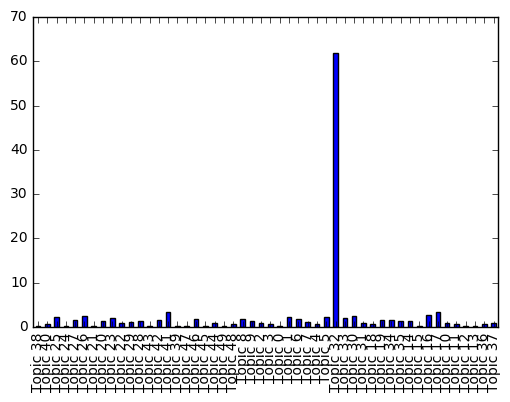

In [169]:
average_topics.plot(kind='bar', legend=False)

In [49]:
#Let's take a look at what kind of restaurants the user likes 
good_restaurants = user_df[user_df['rating'] >= 4]['biz_id']
bis_data = db.get_collection('restaurants')
#Pull each restaurant attribute from the MongoDB
restreview_good = {}
for i in tqdm.tqdm(range(0, len(good_restaurants))):
    rlist = []
    for obj in bis_data.find({'business_id':business_ids[i]}):
        rlist.append(obj)
    restreview_good[business_ids[i]] = rlist

100%|██████████| 169/169 [00:15<00:00, 10.61it/s]


(0, 40)

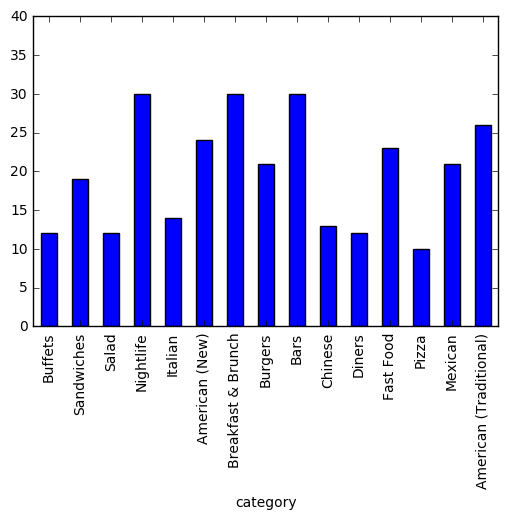

In [125]:
#Get all the categories for the good restaurants 

good_list = []
for key in restreview_good.keys():
    good_list.extend(restreview_good[key][0]['categories'])
good_list = [word for word in good_list if (word != u'Restaurants')]
good_list = [word for word in good_list if (word != u'Food')]
unique_categories = list(set(good_list))
category_count = [good_list.count(cat) for cat in unique_categories]
category_list = [(a,b) for (a,b) in zip(unique_categories, category_count) if b >= 10]
unique_categories = [a for (a,b) in category_list] 
category_count = [b for (a,b) in category_list]
biz_category = pd.DataFrame({'category': unique_categories, 'count': category_count})

#Plot only categories that show up at least 10 times
good_plt = biz_category.plot(x='category', y='count', kind='bar', legend=False)
good_plt.set_ylim(0,40)

In [ ]:
# PUT IN A LSA representation